In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector, DensityMatrix
from qiskit_aer import Aer
from qiskit_experiments.library import StateTomography
import numpy as np


In [16]:
## defs

def create_bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

<IPython.core.display.Latex object>

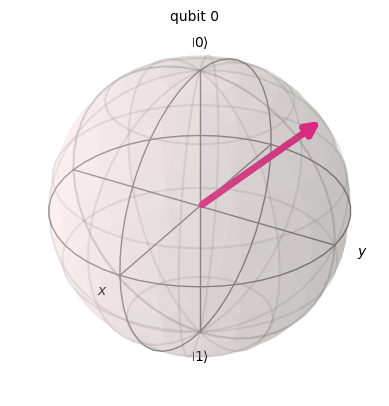

In [17]:
psi = random_statevector(2)

display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

plot_bloch_multivector(psi)

# Alice's State Bloch Vector Comparing with Bob's State Bloch Vector for Error Analysis

In [7]:
density_matrix_a = DensityMatrix(psi)

# Step 4: Calculate the Bloch vector coordinates
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Calculate the components of the Bloch vector
x_a = np.real(np.trace(density_matrix_a.data @ sigma_x))
y_a = np.real(np.trace(density_matrix_a.data @ sigma_y))
z_a = np.real(np.trace(density_matrix_a.data @ sigma_z))

# Combine the coordinates into a Bloch vector
bloch_vecto_a = np.array([x_a, y_a, z_a])

In [18]:
## SETUP

# Protocol uses 3 qubits and 2 classical bits in two different registers
qr = QuantumRegister(3, name='q')
crz, crx = ClassicalRegister(1, name='crz'), ClassicalRegister(1, name='crx')
teleportation_circuit = QuantumCircuit(qr, crz, crx)

teleportation_circuit.initialize(psi, 0)
teleportation_circuit.barrier()

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)



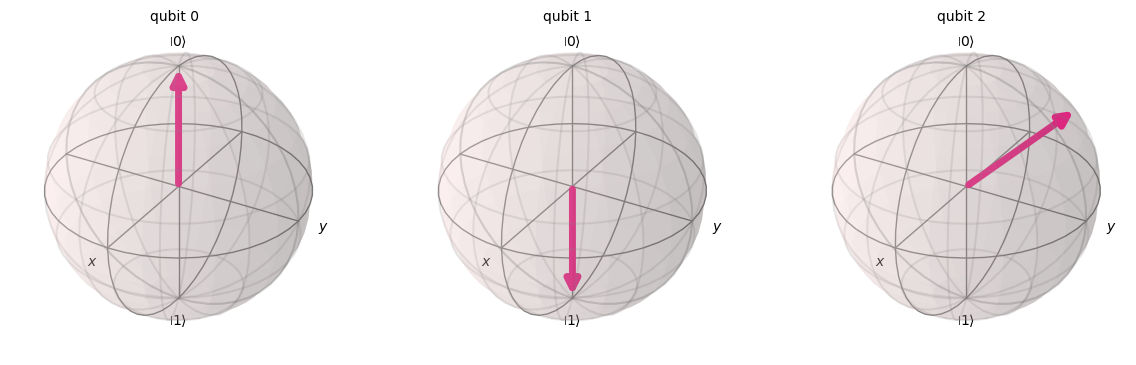

In [19]:
sim = Aer.get_backend('aer_simulator')
teleportation_circuit.save_statevector()
out_vector = sim.run(teleportation_circuit).result().get_statevector()
plot_bloch_multivector(out_vector)

In [20]:
out_vector

Statevector([ 0.        +0.j        , -0.        +0.j        ,
             -0.8310766 -0.28703482j,  0.        +0.j        ,
              0.        -0.j        ,  0.        +0.j        ,
              0.42359233-0.2179271j , -0.        +0.j        ],
            dims=(2, 2, 2))


In [21]:
tomo = StateTomography(teleportation_circuit, 2)

In [22]:
exp_data = tomo.run(sim, shots=5000).block_for_results()  # Waits for results


In [23]:
density_matrix = exp_data.analysis_results("state").value

In [24]:
print("Reconstructed density matrix:")
print(density_matrix)

Reconstructed density matrix:
DensityMatrix([[ 0.19016661+0.00000000e+00j, -0.0018726 -8.27796180e-03j,
                 0.00180111-2.89852073e-03j,  0.00209085-7.48103451e-03j,
                -0.06855188-7.71122190e-02j, -0.0004369 +9.56756928e-04j,
                -0.00111048-2.15208177e-03j,  0.00180193-9.16868678e-04j],
               [-0.0018726 +8.27796180e-03j,  0.19529313+0.00000000e+00j,
                -0.00174978-5.90202597e-03j, -0.00094743+2.91755959e-04j,
                -0.00078924-2.18512807e-03j, -0.07452854-7.24609527e-02j,
                -0.00469045+1.48857621e-03j,  0.00133279+1.78467338e-03j],
               [ 0.00180111+2.89852073e-03j, -0.00174978+5.90202597e-03j,
                 0.18912536+0.00000000e+00j,  0.0012589 +6.05833860e-03j,
                 0.00295859+4.93146411e-04j, -0.00550716-5.34969109e-03j,
                -0.07116741-7.08151454e-02j, -0.00295291-5.53722219e-04j],
               [ 0.00209085+7.48103451e-03j, -0.00094743-2.91755959e-04j,
     

In [25]:
from qiskit.quantum_info import DensityMatrix, partial_trace

# Convert the density matrix to a Qiskit DensityMatrix object
dm = DensityMatrix(density_matrix)

# Perform a partial trace over the unwanted qubits
reduced_dm = partial_trace(dm, [0, 1])  # Trace out qubits 0 and 1

# Print the reduced density matrix for Bob's qubit
print("Reduced density matrix for Bob's qubit:")
print(reduced_dm)


Reduced density matrix for Bob's qubit:
DensityMatrix([[ 0.76684367+0.00000000e+00j, -0.28655495-2.97729702e-01j],
               [-0.28655495+2.97729702e-01j,  0.23315633-8.67361738e-19j]],
              dims=(2,))


In [26]:
from qiskit.quantum_info import DensityMatrix

purity = reduced_dm.purity()
print("Purity of the density matrix:", purity)

# Check if it's pure
if purity == 1:
    print("The state is pure.")
else:
    print("The state is mixed.")

Purity of the density matrix: (0.9839245201463274+0j)
The state is mixed.


Bloch vector coordinates: [-0.5731099063975651, 0.5954594045633465, 0.5336873363671713]


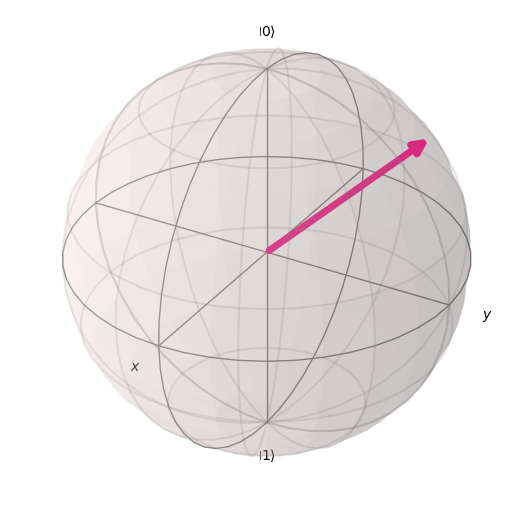

In [28]:
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import DensityMatrix
import numpy as np
reduced_density_matrix = DensityMatrix(reduced_dm)

# Calculate the Bloch vector components
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

x_b = np.real(np.trace(reduced_density_matrix.data @ sigma_x))
y_b = np.real(np.trace(reduced_density_matrix.data @ sigma_y))
z_b = np.real(np.trace(reduced_density_matrix.data @ sigma_z))

bloch_vector_b = [x_b, y_b, z_b]

print("Bloch vector coordinates:", bloch_vector_b)

# Plot the Bloch vector
plot_bloch_vector(bloch_vector_b)


# Error Analysis Section

In [29]:
import numpy as np
import matplotlib.pyplot as plt

bloch_vecto_a 
bloch_vector_b   
# Hasnt completed yet

NameError: name 'bloch_vecto_a' is not defined